In [1]:
import os
import cv2
import asyncio
import hashlib
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from pathlib import Path
from keras import layers
import concurrent.futures
from keras.layers import *
from keras.models import Model
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import LearningRateScheduler
from keras.utils import plot_model, to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
!pip show kaggle > /dev/null || pip install kaggle

kaggle_dir = os.path.expanduser("~/.kaggle")
kaggle_json = "kaggle.json"

# Create the .kaggle directory and move the kaggle.json file
if not os.path.exists(kaggle_dir):
    os.makedirs(kaggle_dir)
    os.rename(kaggle_json, os.path.join(kaggle_dir, kaggle_json))
    os.chmod(os.path.join(kaggle_dir, kaggle_json), 0o600)

datasets = [
    ("tawsifurrahman/covid19-radiography-database", "/content/covid19-radiography-database.zip")
]

def download_dataset(data):
    """
    Download a dataset if it doesn't exist locally.

    Args:
        data: A tuple containing the dataset ID and filename.

    Returns:
        None
    """
    dataset_id, filename = data
    if not os.path.exists(filename):
        !kaggle datasets download -d {dataset_id} -p /content

def extract_dataset(dataset):
    """
    Extract a dataset if it hasn't been extracted before.

    Args:
        dataset: A tuple containing the dataset ID and filename.

    Returns:
        None
    """
    dataset_id, filename = dataset
    if not os.path.exists(dataset_id):
        !unzip -q {filename} -d /content
        os.remove(filename)

def verify_dataset(dataset):
    """
    Verify the integrity of a dataset and remove it if corrupted.

    Args:
        dataset: A tuple containing the dataset ID and filename.

    Returns:
        None
    """
    dataset_id, filename = dataset
    if not os.path.exists(dataset_id):
        expected_hash = dataset_id.split("/")[1]
        with open(filename, "rb") as file:
            file_hash = hashlib.md5(file.read()).hexdigest()
            if file_hash == expected_hash:
                os.remove(filename)
            else:
                print(f"Corrupted file: {filename}")

# Download datasets in parallel
with concurrent.futures.ThreadPoolExecutor() as executor:
    executor.map(download_dataset, datasets)

# Extract datasets in parallel
with concurrent.futures.ThreadPoolExecutor() as executor:
    executor.map(extract_dataset, datasets)

# Verify dataset integrity and remove corrupted files
with concurrent.futures.ThreadPoolExecutor() as executor:
    executor.map(verify_dataset, datasets)

 97% 754M/778M [00:06<00:00, 173MB/s]
100% 778M/778M [00:06<00:00, 133MB/s]


In [3]:
# dataset = Path(r"C:\Users\ashva\Work\Projects\researchAI\Pneumonia Detection\datasets")
dataset = Path(r"/content") # colab
# dataset = Path(r"/kaggle/input/") # kaggle
covid_19 = dataset / "COVID-19_Radiography_Dataset" # colab
# covid_19 = dataset / "covid19-radiography-database" / "COVID-19_Radiography_Dataset" # kaggle

In [4]:
# Create a defaultdict to map classes to their respective file lists
class_mapping = defaultdict(list)

In [5]:
def append_file_names(directory, cls_name):
    """
    Append file names from a given directory to the corresponding class in the class_mapping dictionary.

    Args:
        directory (str): Directory path.
        cls_name (str): Name of the class.
    """
    for f_name in os.listdir(directory):
        if f_name.endswith((".jpeg", ".png")):
            class_mapping[cls_name].append(os.path.join(directory, f_name))

In [6]:
for covid_class in ["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"]:
    append_file_names(covid_19 / f"{covid_class}" / 'images', f"{covid_class}")

In [7]:
classes = list(class_mapping.keys())

image_paths = []
labels = []

for class_name, file_paths in class_mapping.items():
    for file_path in tqdm(file_paths, desc=f"Processing {class_name}"):
        image_paths.append(file_path)
        labels.append(class_name)

Processing Viral Pneumonia: 100%|██████████| 1345/1345 [00:00<00:00, 1269142.61it/s]


In [8]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)

In [9]:
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths,
                                                                      labels,
                                                                      test_size=0.2,
                                                                      random_state=42)

train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths,
                                                                    train_labels,
                                                                    test_size=0.2,
                                                                    random_state=42)

In [10]:
BATCH_SIZE = 16

train_steps = len(train_paths) // BATCH_SIZE
val_steps = len(val_paths) // BATCH_SIZE
test_steps = len(test_paths) // BATCH_SIZE

print("Train samples:", len(train_paths))
print("Validation samples:", len(val_paths))
print("Test samples:", len(test_paths))
print("Train steps per epoch:", train_steps)
print("Validation steps per epoch:", val_steps)
print("Test steps per epoch:", test_steps)

Train samples: 13545
Validation samples: 3387
Test samples: 4233
Train steps per epoch: 846
Validation steps per epoch: 211
Test steps per epoch: 264


In [11]:
def image_generator(img_paths, img_labels, batch_s):
    """
    Generator function to load and preprocess images in batches.

    Args:
        img_paths (list): List of image file paths.
        img_labels (list): List of corresponding image labels.
        batch_s (int): Size of the batch.

    Yields:
        tuple: A tuple containing the batch of images and their corresponding labels.
    """
    num_samples = len(img_paths)
    while True:
        for offset in range(0, num_samples, batch_s):
            batch_paths = img_paths[offset:offset + batch_s]
            batch_labels = img_labels[offset:offset + batch_s]

            batch_images = []
            for img_path in batch_paths:
                image = cv2.imread(img_path)
                resized_image = cv2.resize(image, (224, 224))
                normalized_image = resized_image / 255.0
                batch_images.append(normalized_image)

            yield np.array(batch_images), to_categorical(batch_labels, num_classes)

In [12]:
train_generator = image_generator(train_paths, train_labels, BATCH_SIZE)
val_generator = image_generator(val_paths, val_labels, BATCH_SIZE)
test_generator = image_generator(test_paths, test_labels, BATCH_SIZE)

In [13]:
class NegativeImageLayer(Layer):
    """
    Custom layer that converts an image into its negative representation.

    This layer takes an input image tensor and performs element-wise negation to obtain the negative representation of the image.

    Args:
        None
    """

    def __init__(self):
        """
        Initializes the NegativeImageLayer.

        Args:
            None
        """
        super(NegativeImageLayer, self).__init__()

    def build(self, self):
        """
        Builds the NegativeImageLayer.

        This method is called when the layer is connected to the model and creates the layer's weights if necessary.

        Args:
            self (tuple): Shape of the input tensor.

        Returns:
            None
        """
        super(NegativeImageLayer, self).build(self)

    def call(self, self, **kwargs):
        """
        Performs element-wise negation of the input tensor to obtain the negative representation.

        Args:
            self (tf.Tensor): Input tensor representing the image.

        Returns:
            tf.Tensor: Negative representation of the input image tensor.
            :param **kwargs:
        """
        return tf.negative(self)

    def compute_output_shape(self, self):
        """
        Computes the output shape of the layer.

        Args:
            self (tuple): Shape of the input tensor.

        Returns:
            tuple: Output shape of the layer.
        """
        return self

In [14]:
class TwiceMaxMinPooling2D(Layer):
    """
    A custom Keras layer that performs twice the max-min pooling operation on an input tensor.
    """

    def __init__(self, pool_size=(2, 2), strides=2, padding="SAME", **kwargs):
        """
        Initializes the layer with the given parameters.

        Args:
            pool_size: Tuple of two integers, representing the size of the pooling window.
            strides: Integer, representing the stride length.
            padding: String, representing the type of padding to use.

        Returns:
            None.
        """
        super(TwiceMaxMinPooling2D, self).__init__(**kwargs)

        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding

    def get_config(self):
        """
        Returns the configuration of the layer.

        Args:
            None.

        Returns:
            A dictionary representing the configuration of the layer.
        """
        config = super().get_config().copy()
        config.update({
            "pool_size": self.pool_size,
            "strides": self.strides,
            "padding": self.padding
        })
        return config

    def call(self, self=None, **kwargs):
        """
        Performs the max-min pooling operation on the input tensor.

        Args:
            self: Tensor, representing the input tensor.

        Returns:
            Tensor, representing the output of the max-min pooling operation.
        """
        batch, height, width, channel = self.shape

        # Extract patches from the input tensor
        patch = tf.image.extract_patches(self,
                                         sizes=[1, self.pool_size[0], self.pool_size[1], 1],
                                         strides=[1, self.strides, self.strides, 1],
                                         rates=[1, 1, 1, 1],
                                         padding=self.padding)

        out_shape = tf.shape(patch)
        out_batch = out_shape[0]
        out_height = out_shape[1]
        out_width = out_shape[2]
        out_channel = out_shape[3]

        # Reshape the patches for max-min pooling
        patch = tf.reshape(patch, (-1, out_height, out_width, self.pool_size[0]*self.pool_size[1], channel))

        # Perform max-min pooling and return the output
        t = tf.math.reduce_max(patch, axis=3)
        tadd = tf.add(t, t)
        output = tf.subtract(tadd, tf.math.reduce_min(patch, axis=3))
        output = tf.cast(output, tf.float32)

        return output

In [15]:
def create_metrics():
    """
    Creates instances of the 'Recall' and 'Precision' metrics and defines a custom function 'f1_score'
    to measure the model's performance.

    Returns:
    tuple: A tuple of the 'Recall' and 'Precision' metrics, and the 'F1' score function.
    """
    @tf.function
    def f1_score(y_true, y_pred):
        """
        Calculates the F1 score of a model's performance given true and predicted labels.

        Parameters:
        y_true (tensor): The true labels.
        y_pred (tensor): The predicted labels.

        Returns:
        float: The F1 score.
        """
        # count the number of true positives
        true_positives = tf.keras.backend.sum(
            tf.keras.backend.round(
                tf.keras.backend.clip(
                    y_true * y_pred, 0, 1
                )
            )
        )
        # count the number of possible positives
        possible_positives = tf.keras.backend.sum(
            tf.keras.backend.round(
                tf.keras.backend.clip(
                    y_true, 0, 1
                )
            )
        )
        # count the number of predicted positives
        predicted_positives = tf.keras.backend.sum(
            tf.keras.backend.round(
                tf.keras.backend.clip(
                    y_pred, 0, 1
                )
            )
        )
        precision_ = true_positives / (predicted_positives + tf.keras.backend.epsilon())
        recall_ = true_positives / (possible_positives + tf.keras.backend.epsilon())
        f1_val = 2*(precision_*recall_)/(precision_ + recall_ + tf.keras.backend.epsilon())
        return f1_val

    recall_metric = tf.keras.metrics.Recall()
    precision_metric = tf.keras.metrics.Precision()
    f1_score_metric = f1_score
    return recall_metric, precision_metric, f1_score_metric

In [16]:
TOTAL_EPOCHS = 20

def learning_rate_scheduler(epoch, current_learning_rate, initial_learning_rate=1e-4, decay_rate=0.95):
    """
    A function that returns the learning rate for each epoch.

    Args:
        epoch (int): The current epoch.
        current_learning_rate (float): The current learning rate.
        initial_learning_rate (float): The initial learning rate.
        decay_rate (float): The decay rate for the learning rate.

    Returns:
        float: The new learning rate.
    """
    if epoch < (TOTAL_EPOCHS / 3):
        new_learning_rate = initial_learning_rate
    else:
        new_learning_rate = current_learning_rate * decay_rate

    return new_learning_rate

In [17]:
learning_rate_callback = LearningRateScheduler(learning_rate_scheduler)

In [18]:
inputs = layers.Input(shape=[224, 224, 3], name="Input")

# Block 1
x = Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu", name="Conv1")(inputs)
x = DepthwiseConv2D(depth_multiplier=2, kernel_size=(3, 3), padding="same", activation="relu", name="DConv1")(x)
x = BatchNormalization()(x)
blk1 = MaxPooling2D(pool_size=2, strides=2, name="MaxPool1")(x)

# Block 2
x = Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu", name="Conv2")(blk1)
x = DepthwiseConv2D(depth_multiplier=2, kernel_size=(3, 3), padding="same", activation="relu", name="DConv2")(x)
x = BatchNormalization()(x)
blk2 = MaxPooling2D(pool_size=2, strides=2, name="MaxPool2")(x)

# Block 3
x = Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu", name="Conv3")(blk2)
x = Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu", name="Conv4")(x)
x = DepthwiseConv2D(depth_multiplier=2, kernel_size=(3, 3), padding="same", activation="relu", name="DConv3")(x)
x = BatchNormalization()(x)
blk3 = MaxPooling2D(pool_size=2, strides=2, name="MaxPool3")(x)

# Block 4
x = Conv2D(256, kernel_size=(3, 3), padding="same", activation="relu", name="Conv5")(blk3)
x = Conv2D(512, kernel_size=(3, 3), padding="same", activation="relu", name="Conv6")(x)
x = DepthwiseConv2D(depth_multiplier=2, kernel_size=(3, 3), padding="same", activation="relu", name="DConv4")(x)
blk4 = BatchNormalization()(x)

# Block 5

v = NegativeImageLayer()(blk2)
v = MaxPooling2D(pool_size=2, strides=2, name="MaxPool4")(v)

w = TwiceMaxMinPooling2D(pool_size=(4, 4), strides=2)(blk2)

y = Concatenate(name="Block5Concat")([v, w]) # new addition - 1

y = Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu", name="Conv7")(y)
y = Conv2D(64, kernel_size=(5, 5), padding="same", activation="relu", name="Conv8")(y)
y = Conv2D(224, kernel_size=(3, 3), padding="same", activation="relu", name="Conv9")(y)
blk5 = BatchNormalization()(y)

x = Concatenate(name="DirectConcat")([blk4, blk5])

x = GlobalAveragePooling2D(name="GAP")(x)
x = Dense(256, activation="relu", name="FC1")(x)
x = Dense(32, activation="relu", name="FC2")(x)

outputs = Dense(4, activation="softmax", name="OUTPUT")(x)

model = Model(inputs=inputs, outputs=outputs)

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 224, 224, 32  896         ['Input[0][0]']                  
                                )                                                                 
                                                                                                  
 DConv1 (DepthwiseConv2D)       (None, 224, 224, 64  640         ['Conv1[0][0]']                  
                                )                                                             

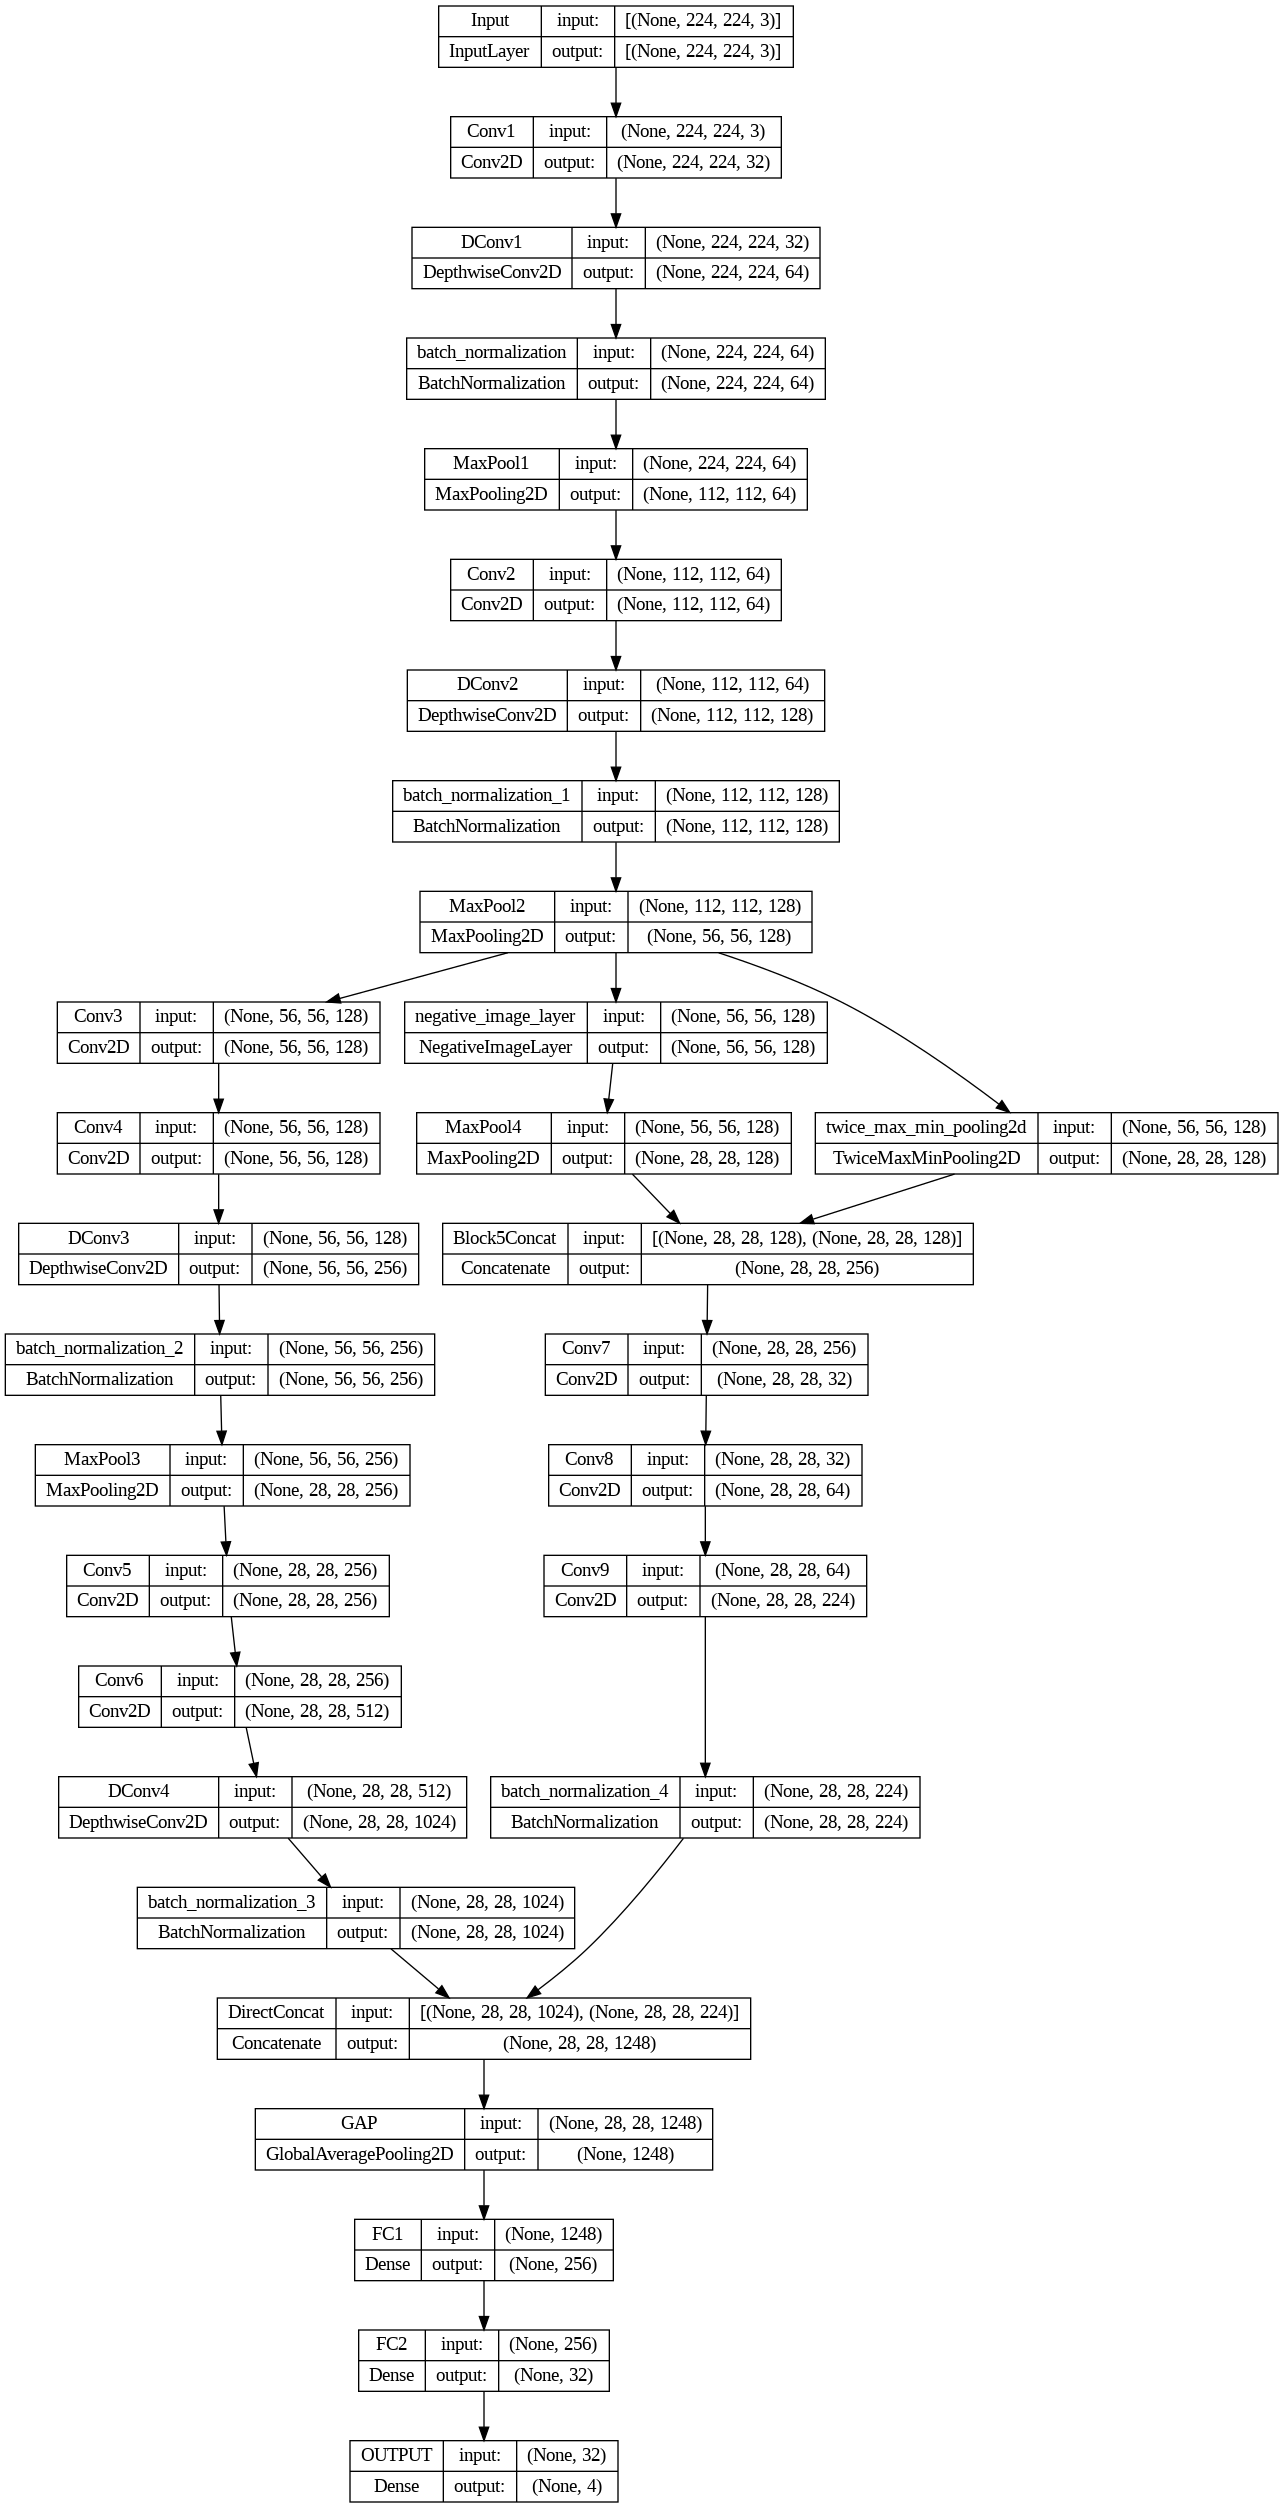

In [20]:
plot_model(model, show_shapes=True)

In [21]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=1e-4),
    metrics=["accuracy", create_metrics()]
)

In [22]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=val_generator,
    validation_steps=val_steps,
    epochs=TOTAL_EPOCHS,
    callbacks=[learning_rate_callback]
)

Epoch 1/20
846/846 [==============================] - 141s 153ms/step - loss: 0.6226 - accuracy: 0.7622 - recall: 0.6815 - precision: 0.8164 - f1_score: 0.7293 - val_loss: 1.1839 - val_accuracy: 0.5299 - val_recall: 0.4994 - val_precision: 0.5407 - val_f1_score: 0.5181 - lr: 1.0000e-04
Epoch 2/20
846/846 [==============================] - 142s 166ms/step - loss: 0.3427 - accuracy: 0.8736 - recall: 0.8586 - precision: 0.8852 - f1_score: 0.8711 - val_loss: 0.4149 - val_accuracy: 0.8383 - val_recall: 0.8238 - val_precision: 0.8531 - val_f1_score: 0.8376 - lr: 1.0000e-04
Epoch 3/20
846/846 [==============================] - 140s 166ms/step - loss: 0.2576 - accuracy: 0.9075 - recall: 0.9021 - precision: 0.9129 - f1_score: 0.9073 - val_loss: 0.2483 - val_accuracy: 0.9031 - val_recall: 0.9017 - val_precision: 0.9070 - val_f1_score: 0.9042 - lr: 1.0000e-04
Epoch 4/20
846/846 [==============================] - 130s 154ms/step - loss: 0.2142 - accuracy: 0.9218 - recall: 0.9183 - precision: 0.926

In [23]:
_ = model.evaluate(test_generator, steps=test_steps)

264/264 [==============================] - 13s 51ms/step - loss: 0.4842 - accuracy: 0.8956 - recall: 0.8949 - precision: 0.8955 - f1_score: 0.8952


In [33]:
def plot_metrics(hist, metric_name_list, y_lim=None, fig_size=(10, 6)):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        hist: a Keras History object containing the training history
        metric_name_list: a list of strings representing the names of the metrics to plot
        y_lim: a tuple (min, max) specifying the limits of the y-axis (optional)
        fig_size: a tuple (width, height) specifying the figure size (optional)

    Returns:
        None
    """
    num_metrics = len(metric_name_list)
    fig, axes = plt.subplots(num_metrics, figsize=(fig_size[0], fig_size[1] * num_metrics))

    for index, metric_name in enumerate(metric_name_list):
        metric = hist.history[metric_name]
        val_metric = hist.history[f"val_{metric_name}"]
        rng = range(1, len(metric) + 1)

        axes[index].plot(rng, metric, label=metric_name)
        axes[index].plot(rng, val_metric, label=f"val_{metric_name}")
        axes[index].legend()
        axes[index].set_xlabel("Epochs")
        axes[index].set_ylabel(metric_name.capitalize())
        axes[index].set_title(f"{metric_name.capitalize()} vs Epochs")

        if metric_name == "loss" and y_lim is not None:
            axes[index].set_ylim(0, 2)
        elif y_lim is not None:
            axes[index].set_ylim(0, 1)

        axes[index].grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

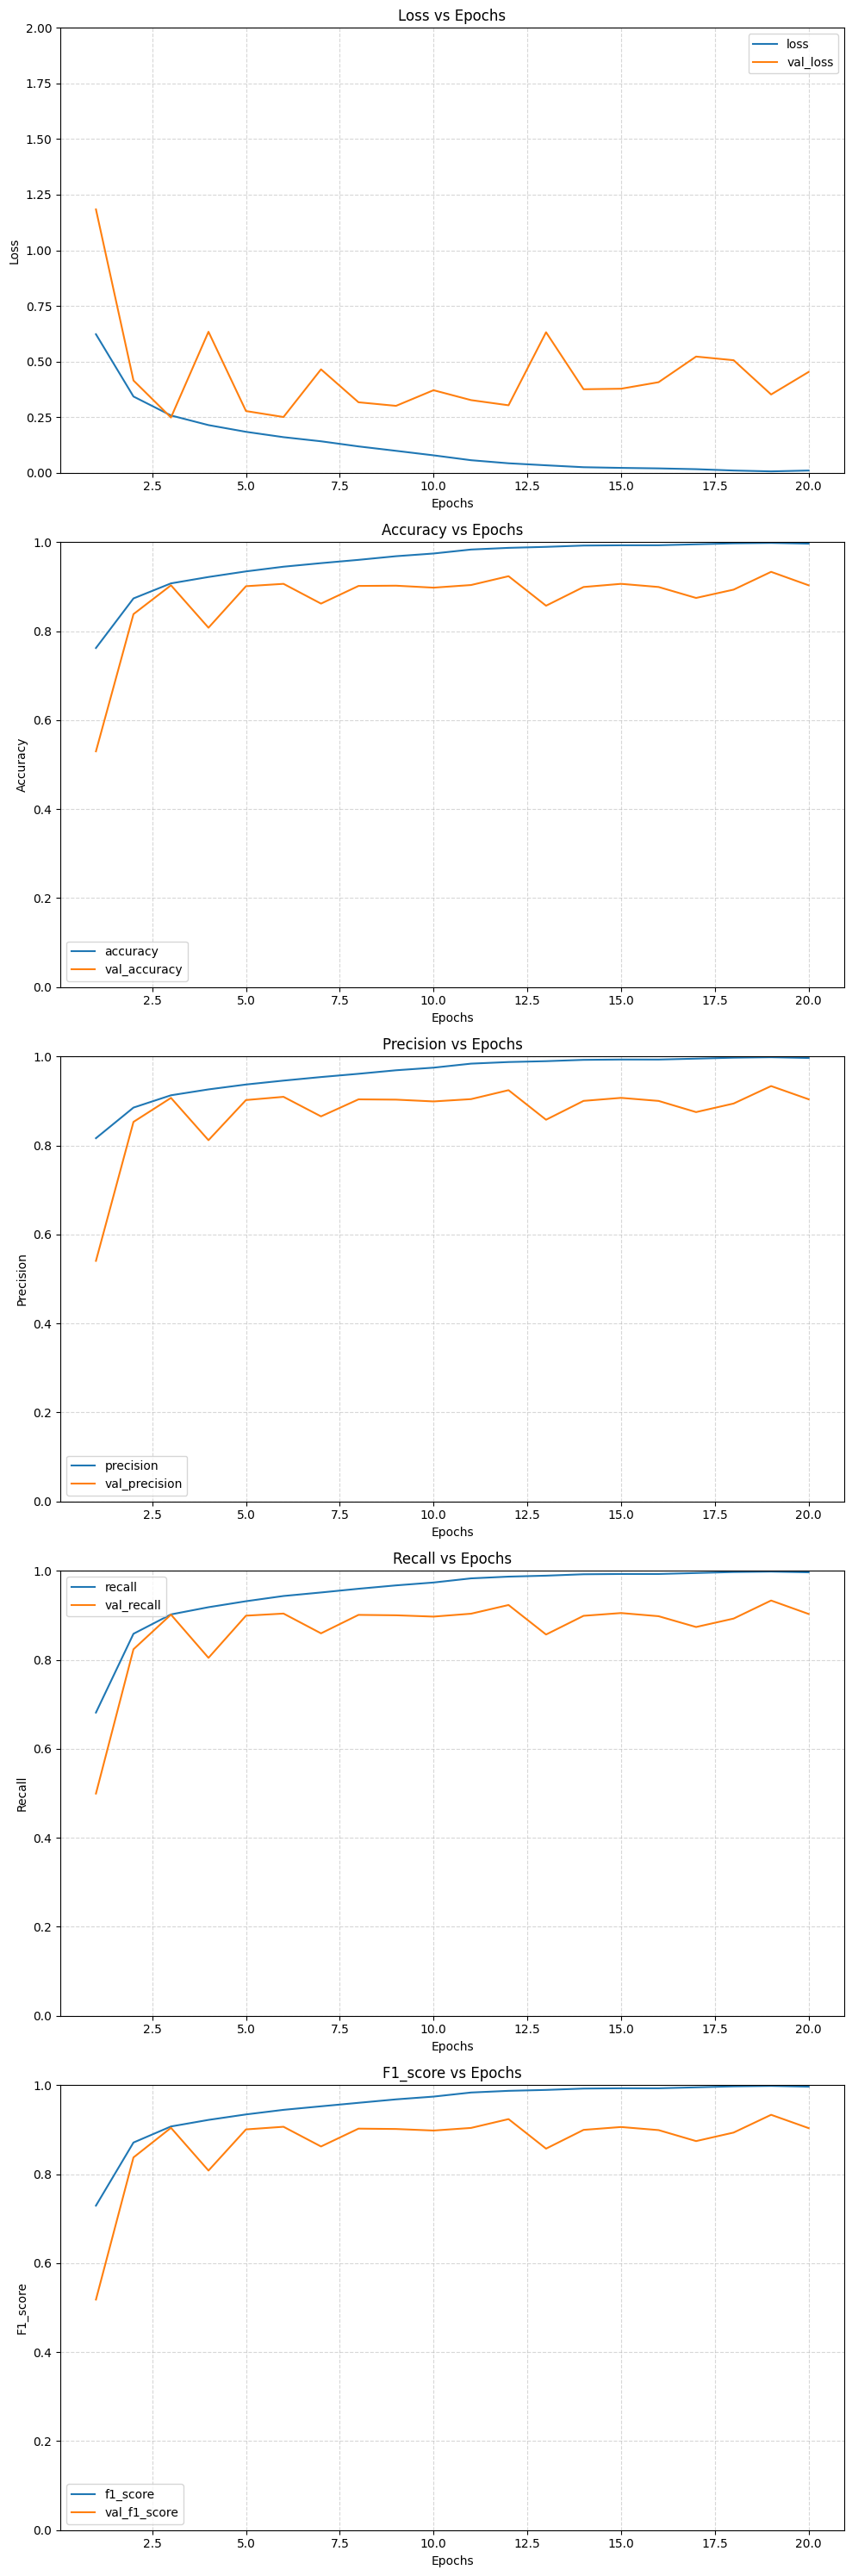

In [34]:
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score"]

plot_metrics(history, metric_names, y_lim=(0, 1))

In [26]:
def generate_model_performance(m, t_gen, t_steps, b_size):
    """
    Generates model performance on each class separately in the dataset.

    Parameters:
        m (tensorflow.keras.models.Model): The trained model.
        t_gen: The generator object for test data.
        t_steps (int): Number of steps for the test data.
        b_size (int): Batch size used for predictions.

    Returns:
        Tuple: A tuple containing true labels and predicted labels.
    """
    y_true = []
    y_pred = []

    preds = m.predict(t_gen, steps=t_steps)

    for i in range(t_steps):
        _, l = next(t_gen)
        y_true.extend(np.argmax(l, axis=1))
        y_pred.extend(np.argmax(preds[i * b_size: (i + 1) * b_size], axis=1))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    cls = label_encoder.classes_
    errors = np.sum(y_pred != y_true)
    tests = len(y_pred)
    accuracy = (1 - errors / tests) * 100

    classification_report_str = classification_report(
        y_true,
        y_pred,
        target_names=cls,
        digits=4,
        zero_division=1
    )

    print(classification_report_str)
    print(f'There were {errors} errors in {tests} tests for an accuracy of {accuracy:6.2f}')

    return y_true, y_pred

In [27]:
true_labels, predicted_labels = generate_model_performance(model, test_generator, test_steps, BATCH_SIZE)

264/264 [==============================] - 13s 50ms/step
                 precision    recall  f1-score   support

          COVID     0.9761    0.9329    0.9540       700
   Lung_Opacity     0.7990    0.9122    0.8519      1242
         Normal     0.9335    0.8619    0.8963      2020
Viral Pneumonia     0.9412    0.9771    0.9588       262

       accuracy                         0.8956      4224
      macro avg     0.9124    0.9210    0.9152      4224
   weighted avg     0.9015    0.8956    0.8967      4224

There were 441 errors in 4224 tests for an accuracy of  89.56


In [28]:
cm = confusion_matrix(true_labels, predicted_labels)

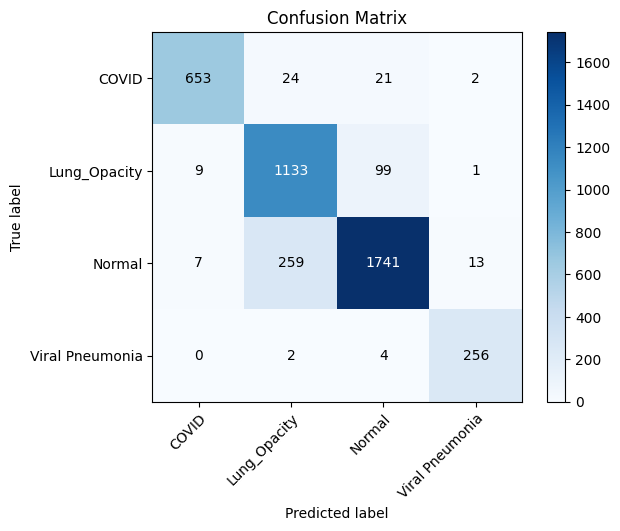

In [29]:
# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Set labels for the confusion matrix
classes = label_encoder.classes_
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       ylabel='True label',
       xlabel='Predicted label',
       title='Confusion Matrix')

# Rotate the x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > np.max(cm) / 2. else "black")

plt.show()

In [30]:
model.save("Models/pneudec-exp18-EXP15.h5")